
# Simple 1H Gap Midpoint Limit Strategy (All-in-One)

**Pipeline**
- Load **1-minute** OHLCV CSV (`timestamp` in UNIX seconds).
- Resample to **1-hour** bars.
- Detect **3-candle FVG** gaps on 1H.
- For each gap, place a **limit order at the midpoint** of the gap:
  - Bullish gap → **long** at midpoint
  - Bearish gap → **short** at midpoint
- Execute when later **1-minute** price touches the limit.
- Exit with **fixed** stop-loss & take-profit in **price units**.
- Output **trades.csv**, equity curve, and PnL bar chart.


In [1]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
from typing import List, Optional
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.width", 200)
pd.set_option("display.max_rows", 200)


In [2]:

# =====================
# User Parameters
# =====================
CSV_PATH = "MES.csv"   # <- set to your CSV
DATA_TZ  = "UTC"
RESAMPLE_RULE = "1H"
STOP_POINTS = 10.0
TAKE_POINTS = 20.0
START_DATE = None
END_DATE   = None
OUTPUT_DIR = "gap_midpoint_results"
TRADES_CSV = "trades.csv"
EQUITY_PNG = "equity_curve.png"
PNL_PNG    = "per_trade_pnl.png"


In [5]:

# ============= Helpers =============
@dataclass
class GapSignal:
    gap_start: pd.Timestamp
    gap_end:   pd.Timestamp
    lower: float
    upper: float
    direction: str
    mid: float
    activated: bool = False
    fill_time: Optional[pd.Timestamp] = None

@dataclass
class Trade:
    entry_time: pd.Timestamp
    direction: str
    entry_price: float
    stop_price: float
    tp_price: float
    exit_time: Optional[pd.Timestamp] = None
    exit_price: Optional[float] = None
    pnl: Optional[float] = None
    gap_start: Optional[pd.Timestamp] = None
    gap_end: Optional[pd.Timestamp] = None

def ensure_dir(p: str):
    Path(p).mkdir(parents=True, exist_ok=True)

def load_1m_csv(path: str, data_tz="UTC"):
    df = pd.read_csv(path)
    req = {"time","open","high","low","close","Volume"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"CSV missing columns: {missing}")
    df["timestamp"] = pd.to_datetime(df["time"], unit="s", utc=True)
    df = df.sort_values("timestamp").set_index("timestamp")
    for c in ["open","high","low","close","Volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    if data_tz and data_tz.upper() != "UTC":
        df = df.tz_convert("UTC")
    return df

def resample_ohlc(df: pd.DataFrame, rule: str) -> pd.DataFrame:
    o = df["open"].resample(rule).first()
    h = df["high"].resample(rule).max()
    l = df["low"].resample(rule).min()
    c = df["close"].resample(rule).last()
    v = df["Volume"].resample(rule).sum()
    return pd.DataFrame({"open":o,"high":h,"low":l,"close":c,"Volume":v}).dropna()

def detect_fvgs(df_h: pd.DataFrame) -> List[GapSignal]:
    hi, lo, idx = df_h["high"], df_h["low"], df_h.index
    signals: List[GapSignal] = []
    for i in range(2, len(df_h)):
        if lo.iloc[i] > hi.iloc[i-2]:  # bullish
            lower = hi.iloc[i-2]; upper = lo.iloc[i]
            signals.append(GapSignal(idx[i-2], idx[i], lower, upper, "bullish", (lower+upper)/2))
        if hi.iloc[i] < lo.iloc[i-2]:  # bearish
            lower = hi.iloc[i]; upper = lo.iloc[i-2]
            signals.append(GapSignal(idx[i-2], idx[i], lower, upper, "bearish", (lower+upper)/2))
    return signals

def backtest_gap_mid_limits(df_1m: pd.DataFrame, gaps: List[GapSignal],
                            stop_pts: float, take_pts: float) -> pd.DataFrame:
    trades: List[Trade] = []

    for ts, row in df_1m.iterrows():
        o, h, l, c = row["open"], row["high"], row["low"], row["close"]

        # activate signals
        for sig in gaps:
            if sig.activated or ts < sig.gap_end:
                continue
            if sig.direction == "bullish":
                if l <= sig.mid:
                    entry = sig.mid; sl = entry - stop_pts; tp = entry + take_pts
                    trades.append(Trade(ts, "bullish", entry, sl, tp, gap_start=sig.gap_start, gap_end=sig.gap_end))
                    sig.activated = True; sig.fill_time = ts
            else:
                if h >= sig.mid:
                    entry = sig.mid; sl = entry + stop_pts; tp = entry - take_pts
                    trades.append(Trade(ts, "bearish", entry, sl, tp, gap_start=sig.gap_start, gap_end=sig.gap_end))
                    sig.activated = True; sig.fill_time = ts

        # manage exits
        for tr in trades:
            if tr.exit_time is not None: 
                continue
            if tr.direction == "bullish":
                hit_stop = l <= tr.stop_price
                hit_tp   = h >= tr.tp_price
            else:
                hit_stop = h >= tr.stop_price
                hit_tp   = l <= tr.tp_price

            if hit_stop and hit_tp:
                tr.exit_time = ts; tr.exit_price = tr.stop_price
            elif hit_stop:
                tr.exit_time = ts; tr.exit_price = tr.stop_price
            elif hit_tp:
                tr.exit_time = ts; tr.exit_price = tr.tp_price

            if tr.exit_time is not None:
                tr.pnl = (tr.exit_price - tr.entry_price) if tr.direction=="bullish" else (tr.entry_price - tr.exit_price)

    return pd.DataFrame([t.__dict__ for t in trades])


In [6]:

# ============= Load, build, run =============
one_min = load_1m_csv(CSV_PATH)
if START_DATE:
    one_min = one_min[one_min.index >= pd.Timestamp(START_DATE, tz="UTC")]
if END_DATE:
    one_min = one_min[one_min.index <= pd.Timestamp(END_DATE, tz="UTC")]

one_h = resample_ohlc(one_min, RESAMPLE_RULE)
gaps = detect_fvgs(one_h)
print(f"Detected {len(gaps)} 1H gaps")
for g in gaps[:10]:
    print(g)


Detected 40 1H gaps
GapSignal(gap_start=Timestamp('2025-10-20 02:00:00+0000', tz='UTC'), gap_end=Timestamp('2025-10-20 04:00:00+0000', tz='UTC'), lower=np.float64(6716.5), upper=np.float64(6721.75), direction='bullish', mid=np.float64(6719.125), activated=False, fill_time=None)
GapSignal(gap_start=Timestamp('2025-10-20 11:00:00+0000', tz='UTC'), gap_end=Timestamp('2025-10-20 13:00:00+0000', tz='UTC'), lower=np.float64(6724.75), upper=np.float64(6731.75), direction='bullish', mid=np.float64(6728.25), activated=False, fill_time=None)
GapSignal(gap_start=Timestamp('2025-10-20 12:00:00+0000', tz='UTC'), gap_end=Timestamp('2025-10-20 14:00:00+0000', tz='UTC'), lower=np.float64(6734.25), upper=np.float64(6747.25), direction='bullish', mid=np.float64(6740.75), activated=False, fill_time=None)
GapSignal(gap_start=Timestamp('2025-10-20 13:00:00+0000', tz='UTC'), gap_end=Timestamp('2025-10-20 15:00:00+0000', tz='UTC'), lower=np.float64(6754.75), upper=np.float64(6762.25), direction='bullish', mi

C:\Users\Severin Spaghetti\AppData\Local\Temp\ipykernel_3084\995105294.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  o = df["open"].resample(rule).first()
C:\Users\Severin Spaghetti\AppData\Local\Temp\ipykernel_3084\995105294.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h = df["high"].resample(rule).max()
C:\Users\Severin Spaghetti\AppData\Local\Temp\ipykernel_3084\995105294.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  l = df["low"].resample(rule).min()
C:\Users\Severin Spaghetti\AppData\Local\Temp\ipykernel_3084\995105294.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  c = df["close"].resample(rule).last()
C:\Users\Severin Spaghetti\AppData\Local\Temp\ipykernel_3084\995105294.py:48: FutureWarning: 'H' is deprecated and will be removed in a futur

In [7]:

trades = backtest_gap_mid_limits(one_min, gaps, STOP_POINTS, TAKE_POINTS)
print(f"Trades taken: {len(trades)}")
trades.head(10)


Trades taken: 35


,entry_time,direction,entry_price,stop_price,tp_price,exit_time,exit_price,pnl,gap_start,gap_end
0,2025-10-20 08:50:00+00:00,bullish,6719.125,6709.125,6739.125,2025-10-20 13:30:00+00:00,6739.125,20.0,2025-10-20 02:00:00+00:00,2025-10-20 04:00:00+00:00
1,2025-10-20 20:00:00+00:00,bullish,6772.125,6762.125,6792.125,2025-10-21 13:57:00+00:00,6762.125,-10.0,2025-10-20 16:00:00+00:00,2025-10-20 18:00:00+00:00
2,2025-10-21 13:08:00+00:00,bullish,6772.375,6762.375,6792.375,2025-10-21 13:57:00+00:00,6762.375,-10.0,2025-10-21 10:00:00+00:00,2025-10-21 12:00:00+00:00
3,2025-10-21 14:52:00+00:00,bearish,6778.625,6788.625,6758.625,2025-10-21 16:46:00+00:00,6788.625,-10.0,2025-10-21 02:00:00+00:00,2025-10-21 04:00:00+00:00
4,2025-10-21 22:00:00+00:00,bearish,6776.625,6786.625,6756.625,2025-10-22 04:11:00+00:00,6786.625,-10.0,2025-10-21 18:00:00+00:00,2025-10-21 20:00:00+00:00
5,2025-10-22 06:00:00+00:00,bullish,6780.250,6770.250,6800.250,2025-10-22 09:12:00+00:00,6770.250,-10.0,2025-10-22 03:00:00+00:00,2025-10-22 05:00:00+00:00
6,2025-10-22 07:06:00+00:00,bullish,6778.125,6768.125,6798.125,2025-10-22 11:10:00+00:00,6768.125,-10.0,2025-10-22 02:00:00+00:00,2025-10-22 04:00:00+00:00
7,2025-10-22 14:27:00+00:00,bullish,6758.500,6748.500,6778.500,2025-10-22 14:31:00+00:00,6748.500,-10.0,2025-10-20 13:00:00+00:00,2025-10-20 15:00:00+00:00
8,2025-10-22 14:46:00+00:00,bullish,6740.750,6730.750,6760.750,2025-10-22 15:01:00+00:00,6760.750,20.0,2025-10-20 12:00:00+00:00,2025-10-20 14:00:00+00:00
9,2025-10-22 16:30:00+00:00,bullish,6728.250,6718.250,6748.250,2025-10-22 16:30:00+00:00,6718.250,-10.0,2025-10-20 11:00:00+00:00,2025-10-20 13:00:00+00:00


In [8]:

# ============= Metrics & Plots =============
def summarize(trades: pd.DataFrame):
    if trades.empty:
        return {"trades":0,"win_rate":0.0,"avg_pnl":0.0,"total_pnl":0.0,"max_dd":0.0}
    pnl = trades["pnl"].fillna(0.0)
    equity = pnl.cumsum()
    roll_max = equity.cummax()
    dd = equity - roll_max
    return {
        "trades": int(len(trades)),
        "win_rate": float((pnl>0).mean()),
        "avg_pnl": float(pnl.mean()),
        "total_pnl": float(pnl.sum()),
        "max_dd": float(dd.min())
    }

summary = summarize(trades)
summary


{'trades': 35,
 'win_rate': 0.4,
 'avg_pnl': 2.0,
 'total_pnl': 70.0,
 'max_dd': -80.0}

Saved trades -> gap_midpoint_results\trades.csv


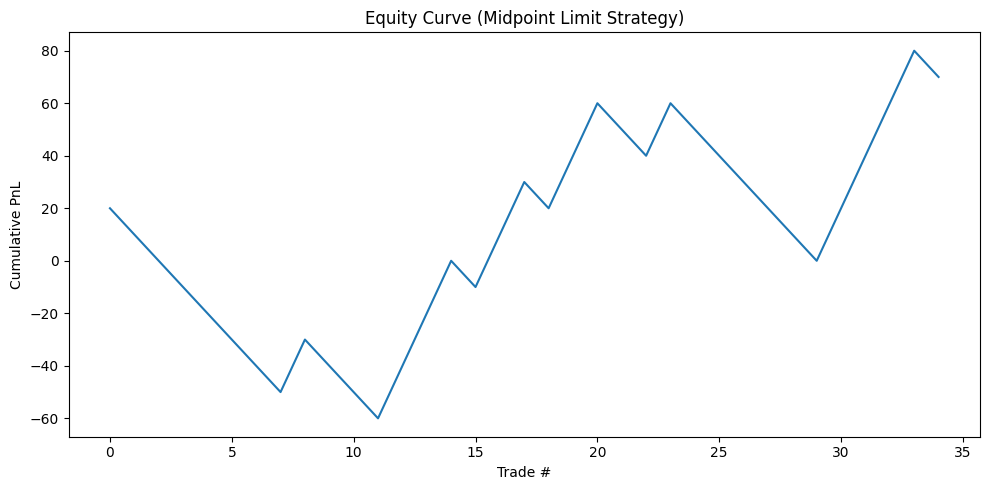

Saved equity curve -> gap_midpoint_results\equity_curve.png


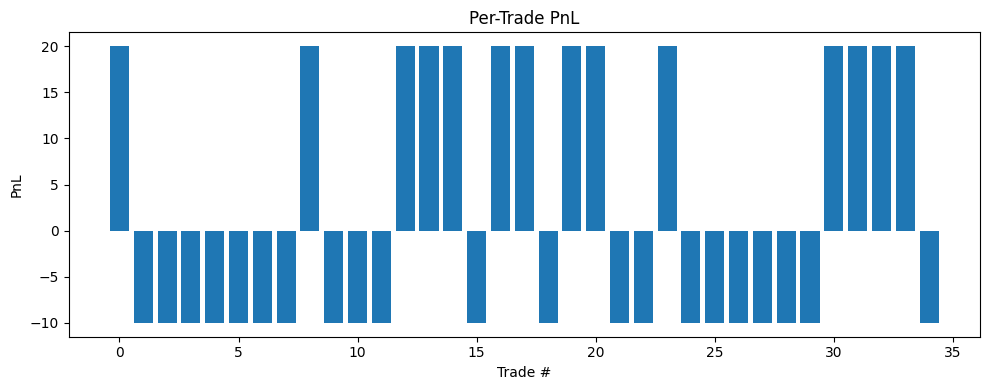

Saved PnL bars -> gap_midpoint_results\per_trade_pnl.png


In [9]:

# Save outputs
ensure_dir(OUTPUT_DIR)
trades_path = str(Path(OUTPUT_DIR) / TRADES_CSV)
trades.to_csv(trades_path, index=False)
print("Saved trades ->", trades_path)

if not trades.empty:
    eq = trades["pnl"].fillna(0.0).cumsum()
    plt.figure(figsize=(10,5))
    plt.plot(range(len(eq)), eq.values)
    plt.title("Equity Curve (Midpoint Limit Strategy)")
    plt.xlabel("Trade #"); plt.ylabel("Cumulative PnL")
    out1 = str(Path(OUTPUT_DIR) / EQUITY_PNG)
    plt.tight_layout(); plt.savefig(out1, dpi=140); plt.show()
    print("Saved equity curve ->", out1)

    plt.figure(figsize=(10,4))
    plt.bar(range(len(trades)), trades["pnl"].fillna(0.0).values)
    plt.title("Per-Trade PnL")
    plt.xlabel("Trade #"); plt.ylabel("PnL")
    out2 = str(Path(OUTPUT_DIR) / PNL_PNG)
    plt.tight_layout(); plt.savefig(out2, dpi=140); plt.show()
    print("Saved PnL bars ->", out2)
else:
    print("No trades to plot.")
